# Config

In [1]:
# Set dark mode as default
import matplotlib.pyplot as plt
import plotly.io as pio
plt.style.use("dark_background")
pio.templates.default = "plotly_dark"

# Imports
from warnings import catch_warnings, filterwarnings
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix, classification_report

from market_regime.data import get_data
from market_regime.features import calculate_log_returns
from market_regime.features import SharpeFeatureBuilder
from market_regime.models import SharpeModel
from market_regime.pipelines.base import RegimePipeline

# Global variables

# Functions
def _tight_symmetric_ylim(ax, pad=0.05, default=0.1):
    """Adjust y-scale for ACF/PACF to be comparable and not dominated by lag-0"""
    ys = []
    for line in ax.lines:
        y = line.get_ydata()
        if y is None or len(y) == 0:
            continue
        ys.append(np.asarray(y, dtype=float))
    if not ys:
        ax.set_ylim(-default, default)
        return
    y_all = np.concatenate(ys)
    y_all = y_all[np.isfinite(y_all)]
    if y_all.size == 0:
        ax.set_ylim(-default, default)
        return
    m = np.max(np.abs(y_all))
    m = max(m, default)
    ax.set_ylim(-(m * (1 + pad)), m * (1 + pad))

# Data

### data import

In [2]:
# Data import (with labels)
df = get_data()

### data transformation

In [3]:
df["log_returns_t"] = calculate_log_returns(df, close_col="close_t", open_col="open_t")
x = df["log_returns_t"].copy()

# Analysis

## log returns

### stationarity of log returns

Lags = 66


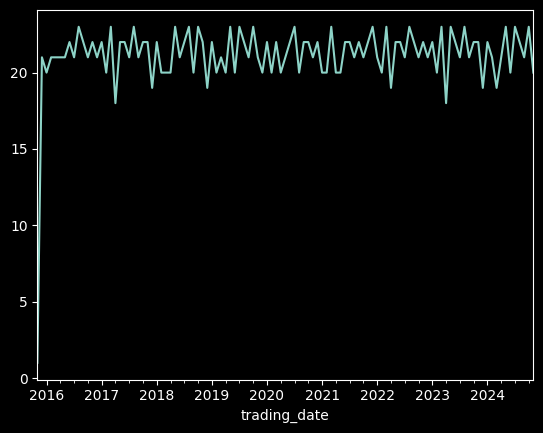

In [4]:
x.groupby([x.index.to_period("M")]).count().plot()
lags = x.groupby([x.index.to_period("M")]).count().rolling(window=3).sum().dropna().astype(int).max() 
print(f"Lags = {lags}")

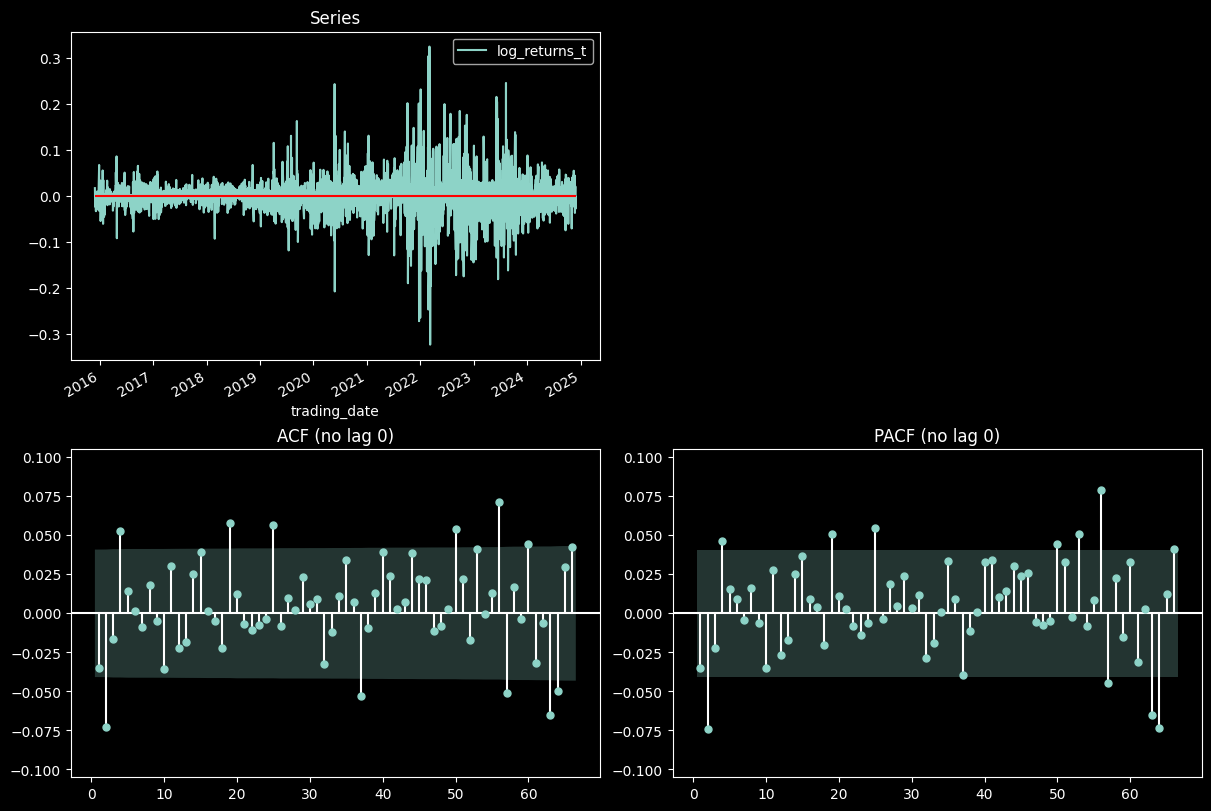

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

# (1) Time series
ax0 = axes[0, 0]
x.plot(ax=ax0, legend=True)
ax0.hlines(y=0, xmin=x.index.min(), xmax=x.index.max(), color="red")
ax0.set_title("Series")

# (2) ACF (no zero-lag)
ax1 = axes[1, 0]
plot_acf(x, ax=ax1, lags=lags, zero=False)
ax1.set_title("ACF (no lag 0)")

# (3) PACF (no zero-lag)
ax2 = axes[1, 1]
plot_pacf(x, ax=ax2, lags=lags, zero=False, method="ywm")
ax2.set_title("PACF (no lag 0)")

# Remove not used plot in grid
axes[0, 1].remove()

_tight_symmetric_ylim(ax1)
_tight_symmetric_ylim(ax2)

plt.show()

#### ADF test

- $H_0$: series has a unit root
- $H_1$: $\sim H_0$ 

In [6]:
adf_stat, adf_pvalue, _, _, adf_crit_values, _ = adfuller(x=x, regression="n")
print(f"ADF test stat: {adf_stat}")
print(f"ADF pvalue: {adf_pvalue}")
print("ADF critical values:")
for pct, val in adf_crit_values.items():
    print(f"  {pct}: {val}")

if adf_pvalue < 0.05:
    result_msg = "H_0 rejected => the series has NO unit root (stationary)."
else:
    result_msg = "failed to reject H_0 => the series has a unit root (non-stationary)."
print(f"\nResult: {result_msg}")

ADF test stat: -24.244326441562027
ADF pvalue: 0.0
ADF critical values:
  1%: -2.5667123495311546
  5%: -1.9411173648459408
  10%: -1.6167050824409557

Result: H_0 rejected => the series has NO unit root (stationary).


#### KPSS test

- $H_0$: the process is trend stationary
- $H_1$: the series has a unit root (series is not stationary)

In [7]:
with catch_warnings():
    filterwarnings("ignore", category=InterpolationWarning)
    kpss_stat, kpss_pvalue, _, kpss_crit_values = kpss(x=x, regression="c")
print(f"KPSS test stat: {kpss_stat}")
print(f"KPSS pvalue: {kpss_pvalue}")
print("KPSS critical values:")
for pct, val in kpss_crit_values.items():
    print(f"  {pct}: {val}")
result_msg = "H_0 rejected." if kpss_pvalue < 0.05 else "failed to reject H_0."
print(f"\nResult: {result_msg}")

KPSS test stat: 0.11003811808660335
KPSS pvalue: 0.1
KPSS critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739

Result: failed to reject H_0.


Conclusion: both tests show that log returns are stationary. Differencing is not needed.

### seasonality of log returns

In [8]:
lags = x.groupby(x.index.year).count().max()
print(lags)
display(x.groupby(x.index.year).count())

257


trading_date
2015     22
2016    256
2017    255
2018    255
2019    256
2020    257
2021    256
2022    257
2023    256
2024    235
Name: log_returns_t, dtype: int64

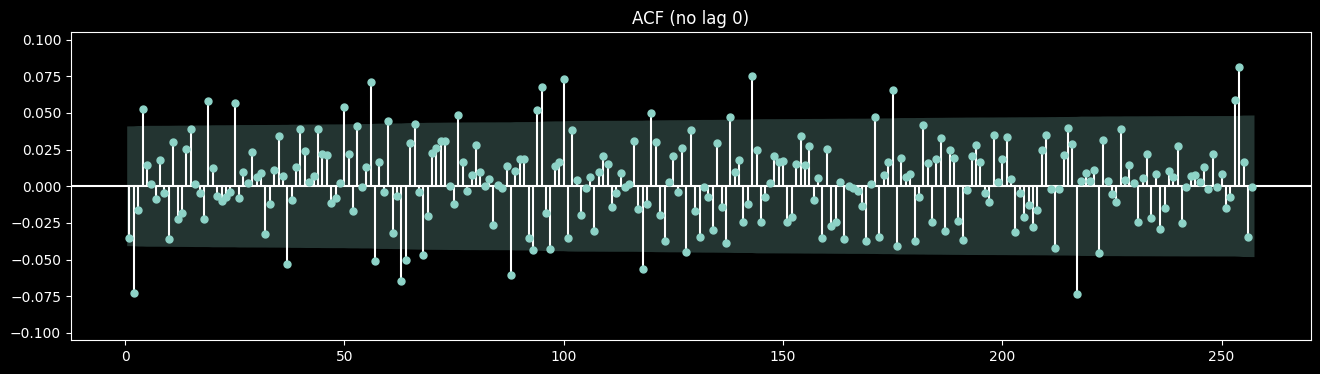

In [9]:
fig, ax = plt.subplots(figsize=(16, 4))
plot_acf(x, ax=ax, lags=lags, zero=False)
ax.set_title("ACF (no lag 0)")
_tight_symmetric_ylim(ax)
plt.show()

#### weekly seasonality

In [10]:
df_ws = x.to_frame()
df_ws["day_of_week"] = df_ws.index.day_of_week
df_x = pd.get_dummies(df_ws["day_of_week"], prefix="day_of_week", drop_first=True).astype(int)
df_x = sm.add_constant(df_x)
s_y = df_ws["log_returns_t"]

In [11]:
res = sm.OLS(endog=s_y, exog=df_x).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_returns_t   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.822
Date:                Fri, 09 Jan 2026   Prob (F-statistic):             0.0237
Time:                        01:12:53   Log-Likelihood:                 3769.2
No. Observations:                2305   AIC:                            -7528.
Df Residuals:                    2300   BIC:                            -7500.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0020      0.002     -0.920      0.357      -0.006       0.002
day_of_week_1     0.0058      0.003      1.866      0.062      -0.000       0.012
day_of_week_2     0.0015      0.003      0.469      0.639      -0.005       0.008
day_of_week_3     0.0023      0.003      0.726      0.468      -0.004       0.008
day_of_week_4    -0.0044      0.003     -1.390      0.165      -0.011       0.002
==============================================================================
Omnibus:                      371.816   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5528.038
Skew:                           0.248   Prob(JB):                         0.00
Kurtosis:                      10.571   Cond. No.                         5.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
res = sm.OLS(endog=s_y, exog=df_x).fit(cov_type="HAC", cov_kwds={"maxlags": 21})    # better for autocorrelation in variance
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_returns_t   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.134
Date:                Fri, 09 Jan 2026   Prob (F-statistic):             0.0742
Time:                        01:12:53   Log-Likelihood:                 3769.2
No. Observations:                2305   AIC:                            -7528.
Df Residuals:                    2300   BIC:                            -7500.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0020      0.003     -0.804      0.421      -0.007       0.003
day_of_week_1     0.0058      0.003      1.834      0.067      -0.000       0.012
day_of_week_2     0.0015      0.003      0.464      0.643      -0.005       0.008
day_of_week_3     0.0023      0.003      0.691      0.490      -0.004       0.009
day_of_week_4    -0.0044      0.004     -1.223      0.221      -0.011       0.003
==============================================================================
Omnibus:                      371.816   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5528.038
Skew:                           0.248   Prob(JB):                         0.00
Kurtosis:                      10.571   Cond. No.                         5.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 21 lags and without small sample correction
"""

#### monthly seasonality

In [13]:
df_ws = x.to_frame()
df_ws["month"] = df_ws.index.month
df_x = pd.get_dummies(df_ws["month"], prefix="month", drop_first=True).astype(int)
df_x = sm.add_constant(df_x)
s_y = df_ws["log_returns_t"]

In [14]:
res = sm.OLS(endog=s_y, exog=df_x).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_returns_t   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.912
Date:                Fri, 09 Jan 2026   Prob (F-statistic):             0.0336
Time:                        01:12:53   Log-Likelihood:                 3774.0
No. Observations:                2305   AIC:                            -7524.
Df Residuals:                    2293   BIC:                            -7455.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.003     -0.711      0.477      -0.009       0.004
month_2       -0.0040      0.005     -0.816      0.415      -0.014       0.006
month_3        0.0027      0.005      0.565      0.572      -0.007       0.012
month_4        0.0022      0.005      0.449      0.653      -0.007       0.012
month_5       -0.0026      0.005     -0.554      0.580      -0.012       0.007
month_6        0.0083      0.005      1.722      0.085      -0.001       0.018
month_7        0.0024      0.005      0.498      0.619      -0.007       0.012
month_8        0.0069      0.005      1.458      0.145      -0.002       0.016
month_9        0.0048      0.005      0.990      0.322      -0.005       0.014
month_10      -0.0030      0.005     -0.637      0.524      -0.012       0.006
month_11       0.0058      0.005      1.208      0.227      -0.004       0.015
month_12      -0.0067      0.005     -1.386      0.166      -0.016       0.003
==============================================================================
Omnibus:                      372.562   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5504.816
Skew:                           0.254   Prob(JB):                         0.00
Kurtosis:                      10.554   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
res = sm.OLS(endog=s_y, exog=df_x).fit(cov_type="HAC", cov_kwds={"maxlags": 21})
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_returns_t   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.656
Date:                Fri, 09 Jan 2026   Prob (F-statistic):            0.00220
Time:                        01:12:53   Log-Likelihood:                 3774.0
No. Observations:                2305   AIC:                            -7524.
Df Residuals:                    2293   BIC:                            -7455.
Df Model:                          11                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.002     -1.042      0.297      -0.007       0.002
month_2       -0.0040      0.003     -1.310      0.190      -0.010       0.002
month_3        0.0027      0.004      0.704      0.482      -0.005       0.010
month_4        0.0022      0.003      0.672      0.502      -0.004       0.009
month_5       -0.0026      0.004     -0.689      0.491      -0.010       0.005
month_6        0.0083      0.004      2.146      0.032       0.001       0.016
month_7        0.0024      0.003      0.690      0.490      -0.004       0.009
month_8        0.0069      0.004      1.938      0.053   -7.74e-05       0.014
month_9        0.0048      0.004      1.188      0.235      -0.003       0.013
month_10      -0.0030      0.004     -0.720      0.472      -0.011       0.005
month_11       0.0058      0.003      1.862      0.063      -0.000       0.012
month_12      -0.0067      0.006     -1.173      0.241      -0.018       0.005
==============================================================================
Omnibus:                      372.562   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5504.816
Skew:                           0.254   Prob(JB):                         0.00
Kurtosis:                      10.554   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 21 lags and without small sample correction
"""

### ARMA

## volatility

### stationarity of volatility

### seasonality of volatility

### GARCH

# Grid Search

Grid search is performed on the first three years of data (768 obs).

This leaves 1537 obs for out of sample model evaluation.

In [16]:
def f1_trend_only(y_true, y_pred):
    mask = np.isin(y_true, [-1, 1])
    return f1_score(y_true[mask], y_pred[mask], labels=[-1, 1], average="macro", zero_division=0)

In [26]:
df_gs = df[df["delivery_date"] < "2019-01-01"].copy()   
tscv = TimeSeriesSplit(n_splits=5, gap=20)
sfb = SharpeFeatureBuilder()

# k_grid = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
k_grid = [None]
mean_grid = ["AR"]                 
lags_grid = list(range(0, 6))    
dist_grid = ["normal", "t"]

# Vol blocks (ARCH vs GARCH)
arch_grid = list(product(["ARCH"], [1, 2, 3], [0], [0]))          # (vol, p, o, q)
garch_grid = list(product(["GARCH"], [1, 2], [0, 1], [1, 2]))     # include o=1

vol_param_grid = arch_grid + garch_grid

# Total iterations for progress bar
gs_iterations = len(k_grid) * len(mean_grid) * len(lags_grid) * len(dist_grid) * len(vol_param_grid)

results = []
best_score = -np.inf
best_params = None

for k, mean, lags, dist, (vol, p, o, q) in tqdm(
    product(k_grid, mean_grid, lags_grid, dist_grid, vol_param_grid),
    total=gs_iterations,
    desc="Grid Search",
):
    params = {
        "mean": mean,
        "lags": lags,
        "vol": vol,
        "p": p,
        "o": o,
        "q": q,
        "dist": dist,
        "k": k,
    }
    rp = RegimePipeline(
        feature_builder=sfb, estimator=SharpeModel(**params)
    )
    fold_scores = []
    for i, (train_idx, test_idx) in enumerate(tscv.split(df_gs)):
        df_train = df_gs.iloc[train_idx, :]
        df_test = df_gs.iloc[test_idx, :]
        rp.fit(df_train)
        y_true = df_test["target"]
        y_pred = rp.predict(df_test)
        score = f1_score(y_true, y_pred, average="macro")
        # score = f1_trend_only(y_true, y_pred)
        fold_scores.append(score)

    mean_score = float(np.nanmean(fold_scores))
    std_score = float(np.nanstd(fold_scores))

    row = {
        **params,
        "mean_f1_macro": mean_score,
        "std_f1_macro": std_score,
        "fold_scores": fold_scores,
    }
    results.append(row)
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print("Best params:", best_params)
print("Best mean f1_macro:", best_score)
display(
    pd.DataFrame(results)
    .sort_values(["mean_f1_macro", "std_f1_macro"], ascending=[False, True])
)

Grid Search:   0%|          | 0/132 [00:00<?, ?it/s]

Best params: {'mean': 'AR', 'lags': 0, 'vol': 'GARCH', 'p': 1, 'o': 0, 'q': 1, 'dist': 'normal', 'k': None}
Best mean f1_macro: 0.18047301125870066


,mean,lags,vol,p,o,q,dist,k,mean_f1_macro,std_f1_macro,fold_scores
3,AR,0,GARCH,1,0,1,normal,None,0.180473,0.010760,"[0.1978021978021978, 0.16764132553606237, 0.17..."
4,AR,0,GARCH,1,0,2,normal,None,0.180473,0.010760,"[0.1978021978021978, 0.16764132553606237, 0.17..."
5,AR,0,GARCH,1,1,1,normal,None,0.180473,0.010760,"[0.1978021978021978, 0.16764132553606237, 0.17..."
6,AR,0,GARCH,1,1,2,normal,None,0.180473,0.010760,"[0.1978021978021978, 0.16764132553606237, 0.17..."
9,AR,0,GARCH,2,1,1,normal,None,0.180473,0.010760,"[0.1978021978021978, 0.16764132553606237, 0.17..."
...,...,...,...,...,...,...,...,...,...,...,...
126,AR,5,GARCH,1,1,1,t,None,0.178234,0.011113,"[0.19521178637200734, 0.16764132553606237, 0.1..."
127,AR,5,GARCH,1,1,2,t,None,0.178234,0.011113,"[0.19521178637200734, 0.16764132553606237, 0.1..."
121,AR,5,ARCH,1,0,0,t,None,0.177824,0.007213,"[0.18455743879472694, 0.16764132553606237, 0.1..."
44,AR,2,ARCH,1,0,0,normal,None,0.174662,0.007031,"[0.1687477181453085, 0.16764132553606237, 0.17..."


In [27]:
print("Best params:", best_params)
print("Best mean f1_macro:", best_score)
display(
    pd.DataFrame(results)
    .sort_values(["mean_f1_macro", "std_f1_macro"], ascending=[False, True])
)

Best params: {'mean': 'AR', 'lags': 0, 'vol': 'GARCH', 'p': 1, 'o': 0, 'q': 1, 'dist': 'normal', 'k': None}
Best mean f1_macro: 0.18047301125870066


,mean,lags,vol,p,o,q,dist,k,mean_f1_macro,std_f1_macro,fold_scores
3,AR,0,GARCH,1,0,1,normal,None,0.180473,0.010760,"[0.1978021978021978, 0.16764132553606237, 0.17..."
4,AR,0,GARCH,1,0,2,normal,None,0.180473,0.010760,"[0.1978021978021978, 0.16764132553606237, 0.17..."
5,AR,0,GARCH,1,1,1,normal,None,0.180473,0.010760,"[0.1978021978021978, 0.16764132553606237, 0.17..."
6,AR,0,GARCH,1,1,2,normal,None,0.180473,0.010760,"[0.1978021978021978, 0.16764132553606237, 0.17..."
9,AR,0,GARCH,2,1,1,normal,None,0.180473,0.010760,"[0.1978021978021978, 0.16764132553606237, 0.17..."
...,...,...,...,...,...,...,...,...,...,...,...
126,AR,5,GARCH,1,1,1,t,None,0.178234,0.011113,"[0.19521178637200734, 0.16764132553606237, 0.1..."
127,AR,5,GARCH,1,1,2,t,None,0.178234,0.011113,"[0.19521178637200734, 0.16764132553606237, 0.1..."
121,AR,5,ARCH,1,0,0,t,None,0.177824,0.007213,"[0.18455743879472694, 0.16764132553606237, 0.1..."
44,AR,2,ARCH,1,0,0,normal,None,0.174662,0.007031,"[0.1687477181453085, 0.16764132553606237, 0.17..."


# OOS Prediction

In [28]:
rp = RegimePipeline(
    feature_builder=SharpeFeatureBuilder(), estimator=SharpeModel(**best_params)
)
oos_days = df[df["delivery_date"] >= "2019-01-01"].index
preds = []
i = 0
for d in tqdm(oos_days, desc="OOS Prediction:"):
    df_train = df.loc[: d - pd.Timedelta(days=1), :]
    df_test = df.loc[[d], :]
    rp.fit(df_train)
    pred = rp.predict(df_test)
    preds.append(pred)
oos_pred = pd.concat(preds).sort_index()

OOS Prediction::   0%|          | 0/1537 [00:00<?, ?it/s]

In [29]:
y_true = df.loc[oos_pred.index, "target"].astype(int)
y_pred = oos_pred.astype(int)

macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
bal_acc = balanced_accuracy_score(y_true, y_pred)

cm = confusion_matrix(y_true, y_pred, labels=[-1, 0, 1])
cm_df = pd.DataFrame(cm, index=["true_-1", "true_0", "true_1"], columns=["pred_-1", "pred_0", "pred_1"])

print(f"OOS Macro-F1:          {macro_f1:.4f}")
print(f"OOS Balanced Accuracy: {bal_acc:.4f}\n")

print("Confusion matrix (rows=true, cols=pred):")
display(cm_df)

print("\nClass distribution:")
print("y_true:\n", y_true.value_counts(normalize=True).sort_index())
print("\ny_pred:\n", y_pred.value_counts(normalize=True).sort_index())

print("\nClassification report:")
print(classification_report(y_true, y_pred, labels=[-1, 0, 1], zero_division=0))

# small preview
oos_eval = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
display(oos_eval.head(20))

OOS Macro-F1:          0.1617
OOS Balanced Accuracy: 0.3327

Confusion matrix (rows=true, cols=pred):


,pred_-1,pred_0,pred_1
true_-1,0,611,4
true_0,0,491,1
true_1,0,430,0



Class distribution:
y_true:
 target
-1    0.400130
 0    0.320104
 1    0.279766
Name: proportion, dtype: float64

y_pred:
 prediction
0    0.996747
1    0.003253
Name: proportion, dtype: float64

Classification report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       615
           0       0.32      1.00      0.49       492
           1       0.00      0.00      0.00       430

    accuracy                           0.32      1537
   macro avg       0.11      0.33      0.16      1537
weighted avg       0.10      0.32      0.16      1537



,y_true,y_pred
trading_date,,
2018-11-30,-1,0
2018-12-03,-1,1
2018-12-04,-1,1
2018-12-05,-1,0
2018-12-06,0,0
2018-12-07,-1,0
2018-12-10,0,0
2018-12-11,0,0
2018-12-12,-1,0
